In [132]:
# Time Independent Schrodinger Equation
# Computational Physics Project 2, Spring 2017
# Ben Zager and Christopher Meierfrankenfeld

import numpy as np
import scipy as sp
from scipy.integrate import odeint,simps
from scipy.optimize import brentq,brenth,newton,bisect,ridder
from scipy.special import airy
import matplotlib.pyplot as plt

In [133]:
# Physical and numerical parameters

L = 10.0 # length to approximate as infinity
nx = 100 # number of grid points
lBound=0; rBound=L; # define domain ([0,L] for triangle potential, [-L,L] for harmonic and well)

x = np.linspace(lBound,rBound,nx) # grid, for linear potential, [0,L], for harmonic potential, [-L,L]
psi0 = 0; u0 = 1; # initial conditions
init = np.array([psi0,u0]) # 
E = 2.0 # Energy, initial guess

# potential function
def V(x):
    return linear(x)
    #return harmonic(x)
    #return well(x)

# Semi-infinite triangular potential
def linear(x):
    if x==0:
        return 10000 # some very large number
    else:
        return x

# harmonic potential
def harmonic(x):
    return x**2

# potential well
def well(x):
    width = 1.0
    height = 4.0
    if np.abs(x) < width/2:
        return 0
    else:
        return height

# psi update function
def f(psi,u,x,E):
    return u

# u update function
def g(psi,u,x,E):
    return 2*(V(x)-E)*psi


In [134]:
# define ODE solvers

# return derivatives for odeint
def deriv(sol,x,E):
    psi,u = sol
    dpsi = f(psi,u,x,E)
    du = g(psi,u,x,E)
    
    return np.array([dpsi,du])

# solves ode for given energy E
def odeSolve(init,x,E):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol

# solves ode for given E and returns value of "psiAtL"
def psiAtL(E,init,x):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol[-1,0]

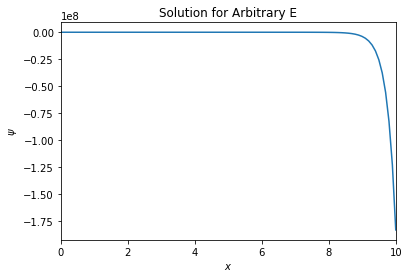

In [135]:
# Test solver and plot

sol = odeSolve(init,x,E)
psi = sol[:,0]; u = sol[:,1]

plt.plot(x,psi)
plt.xlabel(r"$x$"); plt.ylabel(r"$\psi$")
plt.xlim([lBound,rBound]); #plt.ylim([-1,1]);
plt.title("Solution for Arbitrary E")
#plt.axhline(0,color='k'); plt.grid(True);
#plt.savefig("figures/guessPlot_L="+str(int(L))+"_E="+str(int(E))+".png")
plt.show()

In [136]:
# Find solution at L as function of E

EMax = 8 # maximum energy to test
nE = 200 #  grid size
energies = np.linspace(0,EMax,nE) # array of energies
psiE = np.zeros(nE)

for i in range(nE):
    psiE[i] = psiAtL(energies[i],init,x)
    

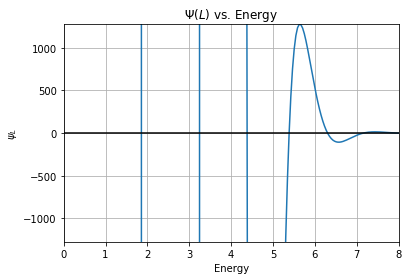

In [137]:
# Plot solution at L as function of E

plt.plot(energies,psiE)
plt.xlabel("Energy"); plt.ylabel(r"$\psi_{L}$")
scale = np.max(psiE[int(0.7*psiE.size):])
plt.xlim([0,EMax]); plt.ylim([-scale,scale]);
plt.axhline(0, color='k'); plt.grid(True);
plt.title(r"$\Psi(L)$ vs. Energy")
#plt.savefig("figures/psiAtL_EMax="+str(EMax)+".png")
plt.show();

[ 1.85575704  3.24460765  4.38167126  5.38661375  6.30526321  7.16129822
  7.96939738]


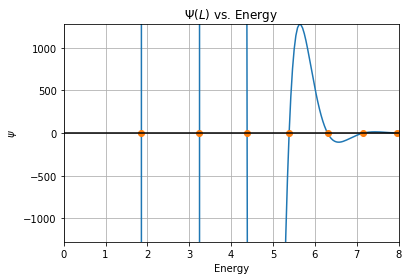

In [138]:
# Root finding

# finds all roots given a "good enough" initial interval [a,b]
# numE,a,b,incr have default values if none are given
# for an interval [a,b], increments b by incr until f(a) and f(b) have opposite signs, then finds root
# after finding a root, shifts a to the root + incr
# stops when b is greater than EMax, or if the number of roots exceeds numE
def rootFinder(x,EMax,init,numE=np.inf,a=0.1,b=0.2,incr=0.1):
    roots = np.empty(0)
    
    while b < EMax and roots.size < numE:
        if (np.sign(psiAtL(a,init,x)) != np.sign(psiAtL(b,init,x))):
            root = brentq(psiAtL,a,b,args=(init,x)) # Brent root finding method
            #root = bisect(psiAtL,a,b,args=(init,x))
            #root = brenth(psiAtL,a,b,args=(init,x))
            roots = np.append(roots,root)
            a = b; b += incr
        else:
            b += incr   
    return roots

roots = rootFinder(x,EMax,init)
print(roots)

plt.plot(energies,psiE)
plt.plot(roots,np.zeros(roots.size), 'o')
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
scale = np.max(psiE[int(0.7*psiE.size):])
plt.xlim([0,EMax]); plt.ylim([-scale,scale]);
plt.title(r"$\Psi(L)$ vs. Energy")
plt.axhline(0,color='k'); plt.grid(True);
#plt.savefig("figures/rootsFound.png")
plt.show()

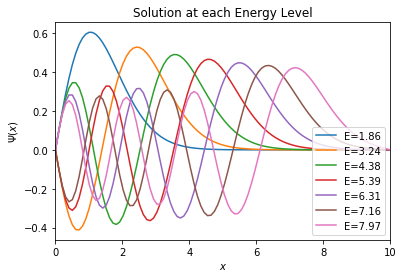

In [139]:
# Plot wavefunction for each energy
sols = np.zeros([nx,roots.size])

for i in range(roots.size):
    if i % 2 != 0:
        init[1] = -1 # set u0=-1 if odd numbered eigenvalue (1st,3rd, ...) to match analytical solution
        sol = odeSolve(init,x,roots[i])
    else:
        init[1] = 1
        sol = odeSolve(init,x,roots[i])
        
    psi = sol[:,0]; u = sol[:,1]
    sols[:,i] = psi
    plt.plot(x,psi,label="E="+str(np.around(roots[i],2)))

plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(lBound,rBound); #plt.ylim(-1,1);
plt.title(r"Solution at each Energy Level")
plt.legend(loc='lower right')
#plt.savefig("figures/wavefunctions.png")
plt.show()

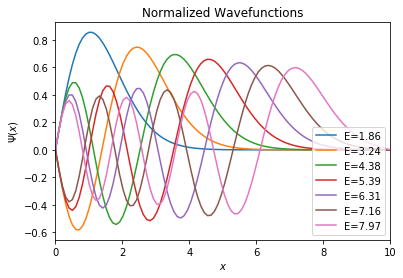

In [140]:
# Normalize wavefunctions
normList = np.zeros(roots.size)
normSols = np.zeros([nx,roots.size])

for i in range(roots.size):
    normList[i] = simps(sols[:,i]**2,x)
    normSols[:,i] = sols[:,i] / np.sqrt(normList[i])
    plt.plot(x,normSols[:,i],label="E="+str(np.around(roots[i],2)))


plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(lBound,rBound)
plt.title("Normalized Wavefunctions")
plt.legend(loc='lower right')
#plt.savefig("figures/normalized.png")
plt.show()

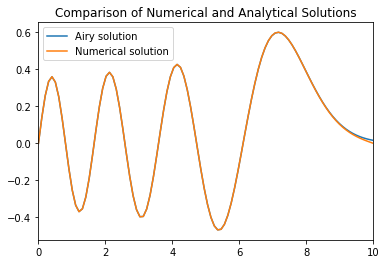

In [141]:
# Compare with analytical solution using Airy functions

airyRoots = np.array([-2.33810,-4.08795,-5.52056,-6.78671,-7.94413,-9.02265,-10.04017,-11.00852,-11.93601])

airyE = -airyRoots / 2**(1/3)

level = 7 # select energy level
xsub = (x-airyE[level-1]) * 2**(1/3)
solA = airy(xsub)[0]
norm = simps(solA**2,x)
normSolA = solA / np.sqrt(norm)

plt.plot(x,normSolA,label="Airy solution");
plt.plot(x,normSols[:,level-1],label="Numerical solution")
plt.xlim(lBound,rBound)
plt.title("Comparison of Numerical and Analytical Solutions")
plt.legend()
plt.savefig("figures/airy_n="+str(level)+".png")
plt.show()

In [129]:
# Plot solutions with varying length

numL = 10 # number of lengths to test
minL = 1; maxL = 6 # min/max length to test
Ls = np.linspace(minL,maxL,numL) # array of lengths
level = 7 # select which energy level

for i in range(numL):
    try:
        x = np.linspace(0,Ls[i],nx) # grid
        roots = rootFinder(x,EMax,init,numE=level)
        sol = odeSolve(init,x,roots[level-1])
        psi = sol[:,0]
        plt.plot(x,psi,label="L="+str(np.around(Ls[i],2)))
    except IndexError:
        pass
            
plt.xlim(0,maxL)
plt.xlabel(r"x"); plt.ylabel(r"\Psi");
plt.legend()
plt.title(r"Solution Using Various Lengths for $E="+str(np.around(roots[level-1],2))+"$")
#plt.savefig("figures/varyL_n="+str(level)+".png")
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


IndexError: index 6 is out of bounds for axis 0 with size 5